# Task

Реализовать суммаризацию текста

Взять тот же датасет, который был на вебинаре и предобученную модель для задачи суммаризации.
Проверить насколько хорошо она суммаризирует

Сделать генерацию заголовков для статьи (обучить модель для генерации заголовков)

In [1]:
!pip install -q transformers
!pip install -q pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [3]:
!ls

gazeta_test.txt  gazeta_train.txt  gazeta_val.txt  sample_data


In [ ]:
!pip install razdel networkx pymorphy2[fast] nltk rouge==0.3.1 summa lexrank sumy
!pip install --upgrade datasets razdel spacy networkx seaborn scipy tqdm tensorflow-text
!python -m spacy download ru_core_news_md

In [5]:
import json
import spacy
import random
import razdel
import pymorphy2
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import Counter, namedtuple

## EDA

In [6]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [7]:
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [8]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [9]:
test_records[0]

{'url': 'https://www.gazeta.ru/science/2020/02/14_a_12960289.shtml',
 'text': 'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, к

In [10]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [11]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


In [12]:
Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary, words_counts, unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()

    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [13]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


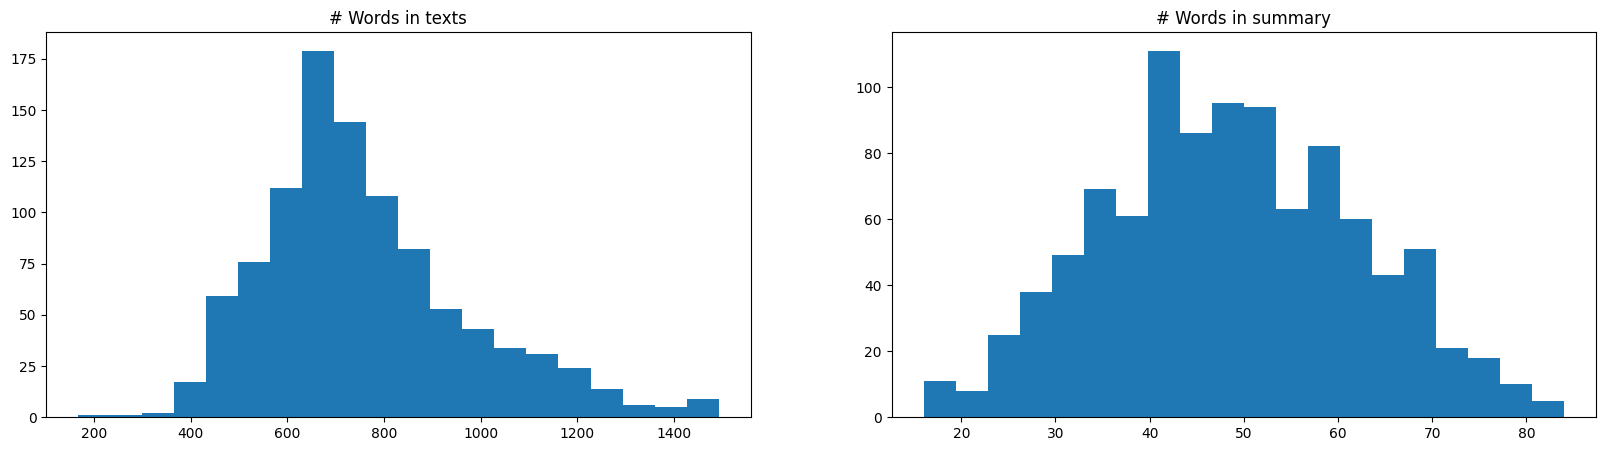

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

## Luhn method

In [15]:
# Список частей речи, которые мы не хотим считать значимыми
# Подбирался на глаз
BAD_POS = ("PREP", "NPRO", "CONJ", "PRCL", "NUMR", "PRED", "INTJ", "PUNCT", "CCONJ", "ADP", "DET", "ADV")

# Загрузка модели для частеречной разметки
spacy_model = spacy.load("ru_core_news_md")


# Метод для разбиения текста на предложения
def sentenize(text):
    return [s.text for s in razdel.sentenize(text)]


# Метод для токенизации предложения
def tokenize_sentence(sentence):
    sentence = sentence.strip().replace("\xa0", "")
    tokens = [token.lemma_ for token in spacy_model(sentence) if token.pos_ not in BAD_POS]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens


# Метод для токенизации всего текста
def tokenize_text(text):
    all_tokens = []
    for sentence in sentenize(text):
        all_tokens.extend(tokenize_sentence(sentence))
    return all_tokens


# Пример работы обоих методов
text = test_records[0]["text"]
sentences = sentenize(text)
print(tokenize_sentence(sentences[0]))
print(tokenize_text(text))

['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие']
['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие', 'четыре', 'проект', 'стать', 'полуфиналист', 'конкурс', 'объявить', 'американский', 'научный', 'команда', 'котором', 'участвовать', 'десять', 'миссия', 'они', 'были', 'отобрать', 'критерий', 'потенциальный', 'польза', 'наука', 'технический', 'осуществимость', 'проект', 'рамка', 'программа', 'discovery', 'nasa', 'заниматься', 'планирование', 'миссия', 'которые', 'призваны', 'дать', 'ответ', 'фундаментальный', 'вопрос', 'происхождение', 'тело', 'солнечный', 'система', 'возможный', 'наличие

In [16]:
class LuhnSummarizer:
    """
    Метод Луна.
    Основано на https://github.com/miso-belica/sumy/blob/main/sumy/summarizers/luhn.py
    Оригинальная статья: https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf
    """
    def __init__(
        self,
        significant_percentage = 0.4, # 40% самых частотных токенов мы считаем значимыми.
        min_token_freq = 2, # Кроме того, слова должны встречаться минимум 2 раза.
        max_gap_size = 4, # Максимальное количество подряд идущих незначимых токенов в промежутках.
        verbose = False # Отладочный вывод для наглядности.
    ):
        self.significant_percentage = significant_percentage
        self.min_token_freq = min_token_freq
        self.max_gap_size = max_gap_size
        self.chunk_ending_mask = [0] * self.max_gap_size
        self.verbose = verbose

    def __call__(self, text, target_sentences_count):
        # Считаем значимые токены.
        all_significant_tokens = self._get_significant_tokens(text)
        if self.verbose:
            print("Значимые токены: ", all_significant_tokens)

        # Считаем значимости предложений.
        ratings = []
        for sentence_index, sentence in enumerate(sentenize(text)):
            # Значимость предложений - максимум из значимостей промежутков.
            sentence_rating = max(self._get_chunk_ratings(sentence, all_significant_tokens))
            if self.verbose:
                print("\tПРЕДЛОЖЕНИЕ. Значимость: {}, текст: {}".format(sentence_rating, sentence))
            ratings.append((sentence_rating, sentence_index))

        # Сортируем предложения по значимости.
        ratings.sort(reverse=True)

        # Оставляем топовые и собираем реферат.
        ratings = ratings[:target_sentences_count]
        indices = [index for _, index in ratings]
        indices.sort()
        return " ".join([sentences[index] for index in indices])

    def _get_significant_tokens(self, text):
        """ Метод для подсчёта того, какие токены являются значимыми. """
        tokens_counter = Counter(tokenize_text(text))
        significant_tokens_max_count = int(len(tokens_counter) * self.significant_percentage)
        significant_tokens = tokens_counter.most_common(significant_tokens_max_count)
        significant_tokens = {token for token, cnt in significant_tokens if cnt >= self.min_token_freq}
        return significant_tokens

    def _get_chunk_ratings(self, sentence, significant_tokens):
        """ Разбиваем предложение на промежтуки и считаем их значимости. """

        tokens = tokenize_sentence(sentence)

        chunks, masks = [], []
        in_chunk = False
        for token in tokens:
            is_significant_token = token in significant_tokens

            if is_significant_token and not in_chunk:
                in_chunk = True
                masks.append([int(is_significant_token)])
                chunks.append([token])
            elif in_chunk:
                last_mask = masks[-1]
                last_mask.append(int(is_significant_token))
                last_chunk = chunks[-1]
                last_chunk.append(token)
            if not chunks:
                continue

            # Проверяем на наличие 4 подряд идущих незначимых токенов.
            # Если встретили - завершаем промежуток.
            last_chunk_ending_mask = masks[-1][-self.max_gap_size:]
            if last_chunk_ending_mask == self.chunk_ending_mask:
                in_chunk = False

        ratings = []
        for chunk, mask in zip(chunks, masks):
            rating = self._get_chunk_rating(mask, chunk)
            ratings.append(rating)
        return ratings

    def _get_chunk_rating(self, original_mask, chunk):
        """ Подсчёт значимости одного промежутка """

        # Убираем незначимые токены в конце промежутка
        original_mask = "".join(map(str, original_mask))
        mask = original_mask.rstrip("0")

        end_index = original_mask.rfind("1") + 1
        chunk = chunk[:end_index]
        assert len(mask) == len(chunk)
        chunk = " ".join(chunk)

        # Считаем значимость
        words_count = len(mask)
        assert words_count > 0
        significant_words_count = mask.count("1")
        assert significant_words_count > 0

        rating = significant_words_count * significant_words_count / words_count
        if self.verbose:
            print("ПРОМЕЖУТОК. Значимость: {}, маска: {}, текст: {}".format(rating, mask, chunk))
        return rating

In [17]:
luhn = LuhnSummarizer(verbose=False)
summary = luhn(text, 3)

print()
print("Текст: {}".format(test_records[0]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[0]["summary"]))


Текст: Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из 

## mBART huggingface

In [18]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00


Возьмём предобученную модель с сайта huggingface.co

In [19]:
from transformers import MBartTokenizer, MBartForConditionalGeneration

model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)

In [20]:
model = MBartForConditionalGeneration.from_pretrained(model_name)
model.to("cuda")

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(250027, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(250027, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm)

In [21]:
article_text = test_records[0]["text"]
input_ids = tokenizer(
    [article_text],
    max_length=600,
    truncation=True,
    return_tensors="pt",
)["input_ids"].to("cuda")
print(input_ids)

tensor([[     6, 230681,  34358, 227683, 204209,  13475, 153827,  40087, 128740,
          14424,  22002,   2097, 181515, 216985,    244, 103499,    983,      4,
           3837,     49,  18777,    130,  13686,   9072,   3505, 137302,    227,
            518,  55735,     35, 119746,  12703,   3150,  54064,   2454,   3216,
             49,  28804,   5434,  93643,   7330,   1114,      5,  68406,  97945,
          30840,  28390, 200007,   7246,   1281,  78716,      4, 123928,   1270,
          25514,  41374,    244, 193145,  31915,      4,     49,  33763, 210551,
            197,   5138,  93643, 103499,    983,      5,   7762,   2792,   7638,
            183,  42437,  14582,    129,  90870,  18419,  43346,  75819,  34512,
          11514,    518,  33034,     35, 150738,    312, 117742,   1595,  11981,
          30840,      5,    417,  23085,  41322, 156457,  40087, 188986,   6314,
          36274,    130, 103499,    983,      4,   3837, 182830,    227,  89418,
         190393,     29, 233

In [22]:
output_ids = model.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4
)[0]
summary = tokenizer.decode(output_ids, skip_special_tokens=True)
print("Текст: {}".format(test_records[0]["text"]))
print("\nИтоговый реферат: {}".format(summary))

Текст: Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из в